![image](resources/qgss-header.png)

# Lab 7: Qubit Spectroscopy

In this lab, you will take what you learned about the interactions between qubits and resonators to perform transmon spectroscopy with the pulse simulator.

### Installing Necessary Packages
Before we begin, you will need to install some prerequisites into your environment. Run the cell below to complete these installations. At the end, the cell outputs will be cleared.

In [1]:
!pip install -U -r grading_tools/requirements.txt

from IPython.display import clear_output
clear_output()

## Simulating the Transmon as a Duffing Oscillator

As you learned in Lecture 6, the transmon can be understood as a Duffing oscillator specified by a frequency $\nu$, anharmonicity $\alpha$, and drive strength $r$, which results in the Hamiltonian
$$
   \hat{H}_{\rm Duff}/\hbar = 2\pi\nu a^\dagger a + \pi \alpha a^\dagger a(a^\dagger a - 1) + 2 \pi r (a + a^\dagger) \times D(t),
$$

where $D(t)$ is the signal on the drive channel for the qubit, and $a^\dagger$ and $a$ are, respectively, the creation and annihilation operators for the qubit. Note that the drive strength $r$ sets the scaling of the control term, with $D(t)$ assumed to be a complex and unitless number satisfying $|D(t)| \leq 1$. 

## Qiskit Pulse Overview

As a brief overview, Qiskit Pulse schedules (experiments) consist of Instructions (i.e., Play) acting on Channels (i.e., the drive channel). Here is a summary table of available Instructions and Channels:

![image](resources/pulse-instr.png)

For more detail, this table summarizes the interaction of the channels with the actual quantum hardware:

![image](resources/pulse-user-device-layers.png)

However, we find it is more instructive to begin with guided programming in Pulse. Below you will learn how to create pulses, schedules, and run experiments on a simulator. These lessons can be immediately applied to actual pulse-enabled quantum hardware, in particular [`ibmq_armonk`](https://www.ibm.com/blogs/research/2019/12/qiskit-openpulse/).

## Let's get started!

In most of the cells below, nothing needs to be modified. **However, you will need to execute the cells by pressing `shift+Enter` in each code block**. In order to keep things tidy and focus on the important aspects of Qiskit Pulse, the following cells make use of methods from the `helper` module. For the gory details, please refer back to the [Lab 7 notebook](lab7-jc-spect-readout.ipynb). Just as in Lab 6, before coming to the discussion of **Sideband Modulation**, the following code blocks

- create backend pulse simulator and instantiate the transmon as a Duffing oscillator of frequency $\sim 5$ GHz
- import libraries for numerics and visualization, and define helpful constants
- create the channels for the pulse schedule and define measurment schedule (we will only work with the drive channel)

In [2]:
# our backend is the Pulse Simulator
from resources import helper
from qiskit.providers.aer import PulseSimulator
backend_sim = PulseSimulator()

# sample duration for pulse instructions 
dt = 1e-9

# create the model
duffing_model = helper.get_transmon(dt)

# get qubit frequency from Duffing model
qubit_lo_freq = duffing_model.hamiltonian.get_qubit_lo_from_drift()

In [3]:
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
kHz = 1.0e3 # kilohertz
us = 1.0e-6 # microseconds
ns = 1.0e-9 # nanoseconds

### Instantiate channels and create measurement schedule

We will use the same measurement schedule throughout, whereas the drive schedules will vary. This must be built for the simulator, for a real backend we can ask for its default measurement pulse.

In [4]:
from qiskit import pulse
from qiskit.pulse import Play, Acquire
from qiskit.pulse.pulse_lib import GaussianSquare

# qubit to be used throughout the notebook
qubit = 0

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

# Construct a measurement schedule and add it to an InstructionScheduleMap
meas_samples = 1200
meas_pulse = GaussianSquare(duration=meas_samples, amp=0.025, sigma=4, width=1150)
measure_sched = Play(meas_pulse, meas_chan) | Acquire(meas_samples, acq_chan, pulse.MemorySlot(qubit))

inst_map = pulse.InstructionScheduleMap()
inst_map.add('measure', [qubit], measure_sched)

# save the measurement/acquire pulse for later
measure = inst_map.get('measure', qubits=[qubit])

## Sideband Modulation

Unlike the case of running on an actual device, with the simulator we can only set the (local) oscillator frequency of the drive, $f_{\rm LO}$, to a single value. In order to sweep frequencies to perform spectroscopy, we use a trick called *sideband modulation*, where we modulate our spectroscopy pulse by a sideband frequency $f_{\rm SB}$ so that the pulse applied to the qubit is of (radio) frequency

$$ f_{\rm RF} = f_{\rm LO} + f_{\rm SB}. $$

This is achieved by multiplying each sample amplitude by a complex exponential 

$$ d_j^{\rm SB} = \sum_j e^{2\pi f_{\rm SB} t_j} d_j $$

but we will tuck the details away in the `helper` module. The important thing is that we must apply the sideband for each pulse in order to change its frequency. 

Now, instead of `assemble`'ing a single schedule with an array of schedule LO's as, we will create a schedule of the same pulse *sidebanded* by an array of sideband frequecies at a fixed LO frequency. Since we are now considering a transmon, we have multiple energy levels we can perform spectroscopy on. We will being with spectroscopy of the $|0\rangle \to |1\rangle$ transition, which is the one used as the qubit, often called the *computational basis*.

In [5]:
from qiskit.pulse import pulse_lib

# the same spect pulse used in every schedule
drive_amp = 0.9
drive_sigma = 16
drive_duration = 128
spec_pulse = pulse_lib.gaussian(duration=drive_duration, amp=drive_amp, 
                                sigma=drive_sigma, name=f"Spec drive amplitude = {drive_amp}")

# Construct an np array of the frequencies for our experiment
spec_freqs_GHz = np.arange(5.0, 5.2, 0.005)

# Create the base schedule
# Start with drive pulse acting on the drive channel
spec_schedules = []
for freq in spec_freqs_GHz:
    sb_spec_pulse = helper.apply_sideband(spec_pulse, qubit_lo_freq[0]-freq*GHz, dt)
    
    spec_schedule = pulse.Schedule(name='SB Frequency = {}'.format(freq))
    spec_schedule += Play(sb_spec_pulse, drive_chan)
    # The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
    spec_schedule += measure << spec_schedule.duration
    spec_schedules.append(spec_schedule)

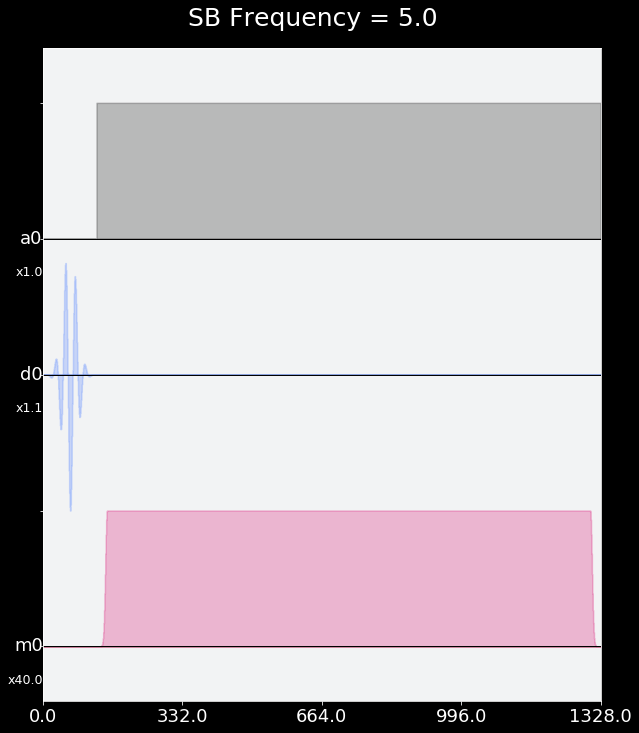

In [6]:
spec_schedules[0].draw()

In [7]:
from qiskit import assemble

# assemble the schedules into a Qobj
spec01_qobj = assemble(**helper.get_params('spec01', globals()))

In [8]:
# run the simulation
spec01_result = backend_sim.run(spec01_qobj, duffing_model).result()

In [9]:
# retrieve the data from the experiment
spec01_values = helper.get_values_from_result(spec01_result, qubit)

We will fit the spectroscopy signal to a Lorentzian function of the form

$$ \frac{AB}{\pi[(f-f_{01})^2 + B^2]} + C $$

to find the qubit frequency $f_{01}$.

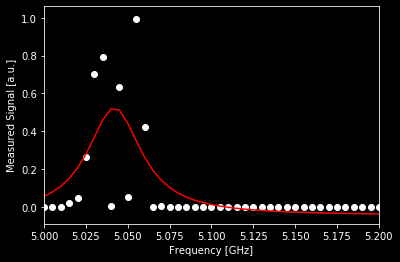

01 Spectroscopy yields 5.042007 GHz


In [10]:
fit_params, y_fit = helper.fit_lorentzian(spec_freqs_GHz, spec01_values, [5, 5, 1, 0])

f01 = fit_params[1]

plt.scatter(spec_freqs_GHz, np.real(spec01_values), color='white') # plot real part of sweep values
plt.plot(spec_freqs_GHz, y_fit, color='red')
plt.xlim([min(spec_freqs_GHz), max(spec_freqs_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

print("01 Spectroscopy yields %f GHz"%f01)

# Exercise 1: Spectroscopy of 1->2 transition

In order to observe the transition between the $|1\rangle$ and $|2\rangle$ states of the transmon, we must apply an $X_\pi$ pulse to transition the qubit from $|0\rangle$ to $|1\rangle$ first. Because we are using the simulator, we must first define our $X_\pi$ pulse from the Rabi experiment in Lab 6.

In [11]:
x180_amp = 0.629070 #from lab 6 Rabi experiment

x_pulse = pulse_lib.gaussian(duration=drive_duration,
                             amp=x180_amp, 
                             sigma=drive_sigma,
                             name='x_pulse')

The anharmonicity of our transmon qubits is typically around $-300$ MHz, so we will sweep around that value. 

In [16]:
anharmonicity_guess_GHz = -0.3

def build_spec12_pulse_schedule(freq):
    sb12_spec_pulse = helper.apply_sideband(spec_pulse, (freq + anharmonicity_guess_GHz)*GHz, dt)
    
    ### create a 12 spectroscopy pulse schedule spec12_schedule (already done)
    ### play an x pulse on the drive channel
    ### play sidebanded spec pulse on the drive channel
    ### add measurement pulse to schedule
    
    spec12_schedule = pulse.Schedule()
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    
    spec12_schedule += Play(x_pulse, drive_chan)
    spec12_schedule += Play(sb12_spec_pulse, drive_chan)
    spec12_schedule += measure << spec12_schedule.duration
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    
    return spec12_schedule

In [17]:
sb_freqs_GHz = np.arange(-.1, .1, 0.005) # sweep +/- 100 MHz around guess

# now vary the sideband frequency for each spec pulse
spec_schedules = []
for freq in sb_freqs_GHz:
    spec_schedules.append(build_spec12_pulse_schedule(freq))

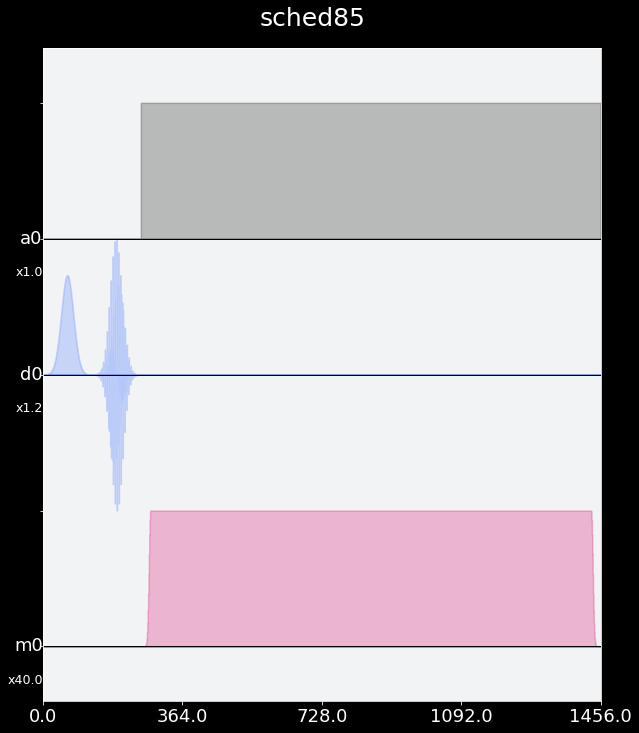

In [18]:
spec_schedules[0].draw()

In [19]:
# assemble the schedules into a Qobj
spec12_qobj = assemble(**helper.get_params('spec12', globals()))
answer1 = spec12_qobj

In [20]:
# run the simulation
spec12_result = backend_sim.run(spec12_qobj, duffing_model).result()

In [21]:
# retrieve the data from the experiment
spec12_values = helper.get_values_from_result(spec12_result, qubit)

We will again fit the spectroscopy signal to a Lorentzian function of the form

$$ \frac{AB}{\pi[(f-f_{12})^2 + B^2]} + C $$

to find the frequency of the $|1\rangle \to |2\rangle$ transition $f_{12}$.

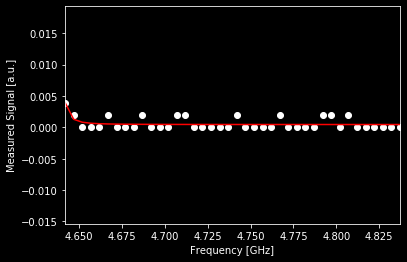

12 Spectroscopy yields 4.637204 GHz
Measured transmon anharmonicity is -404.802851 MHz


In [22]:
anharm_offset = qubit_lo_freq[0]/GHz + anharmonicity_guess_GHz

fit_params, y_fit = helper.fit_lorentzian(anharm_offset + sb_freqs_GHz, spec12_values, [5, 4.5, .1, 3])

f12 = fit_params[1]

plt.scatter(anharm_offset + sb_freqs_GHz, np.real(spec12_values), color='white') # plot real part of sweep values
plt.plot(anharm_offset + sb_freqs_GHz, y_fit, color='red')
plt.xlim([anharm_offset + min(sb_freqs_GHz), anharm_offset + max(sb_freqs_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

print("12 Spectroscopy yields %f GHz"%f12)
print("Measured transmon anharmonicity is %f MHz"%((f12-f01)*GHz/MHz))

# Additional Resources

- The Qiskit textbook sections that cover this material are
  - [Circuit Quantum Electrodynamics](https://qiskit.org/textbook/ch-quantum-hardware/cQED-JC-SW.html)
  - [Accessing Higher Energy States](https://qiskit.org/textbook/ch-quantum-hardware/accessing_higher_energy_states.html)

- Watch the videos
  - [Quantum Coding with Lauren Capelluto](https://www.youtube.com/watch?v=ZvipHRY-URs)
  - ["Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses"](https://www.youtube.com/watch?v=V_as5PufUiU) webinar at CQT by yours truly